# Introduction

In a previous exploration, `Interesting alert.ipynb`, we found an alert of a subway line that was disrupted. In this alert, passengers were advised to use the M7 bus as an alternative mode of transportation. When analysing the data before, during, and after the alert, it appeared that the number of passengers on the M7 bus had significantly increased while the alert was active. In this file, we would like to further build upon this observation, by analyzing the performance of our model on the M7 bus. Specifically, we will attempt to predict passenger numbers for the day during which the alert was active. Then, we will see if it is the case that the model fails to accurately predict during the alert period, as one would expect. Finally, we will introduce a 'disruption' variable into our dataset, which indicates whether an alert was active. Note that, for the latter, we might need to gather more data, as these disruptions happen infrequently.

# Train an M7 model
## Imports

In [59]:
import pandas as pd
import passenger_pred.load as ppl
import passenger_pred.preprocess as ppp
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

## Load M7 data
We load close to a month's worth of M7 data, from October 1st until October 29th. 

In [2]:
M7_DIR = "../data/M7/"

df_m7 = pd.read_csv(M7_DIR + "20211001_20211029_M7.csv")
df_m7.shape

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(383785, 24)

In [3]:
df_m7.head()

,Unnamed: 0,route,timestamp,route_long,direction,service_date,trip_id,gtfs_shape_id,route_short,agency,...,next_stop_d_along_route,next_stop_d,lat,lon,bearing,progress_rate,vehicle_id,gtfs_block_id,passenger_count,progress_status
0,0,M7,2021-10-01 00:00:01-04:00,MTA NYCT_M7,0,2021-09-30,MTA NYCT_OF_D1-Weekday-SDon-143000_M1_139,MTA_M070101,M7,MTA NYCT,...,2565.33,39.11,40.758015,-73.981774,53.130104,normalProgress,MTA NYCT_3891,MTA NYCT_OF_D1-Weekday-SDon_E_OF_21360_M7-207,NaN,NaN
1,1,M7,2021-10-01 00:00:14-04:00,MTA NYCT_M7,1,2021-09-30,MTA NYCT_OF_D1-Weekday-SDon-137500_M7_239,MTA_M070003,M7,MTA NYCT,...,10843.14,91.67,40.747708,-73.992991,233.583620,normalProgress,MTA NYCT_3825,MTA NYCT_OF_D1-Weekday-SDon_E_OF_32100_M7-220,NaN,NaN
2,2,M7,2021-10-01 00:00:26.534000-04:00,MTA NYCT_M7,1,2021-09-30,MTA NYCT_OF_D1-Weekday-SDon-141500_M7_241,MTA_M070003,M7,MTA NYCT,...,5240.97,110.99,40.790863,-73.968999,233.864620,normalProgress,MTA NYCT_9572,MTA NYCT_OF_D1-Weekday-SDon_E_OF_25200_M7-212,8,NaN
3,3,M7,2021-10-01 00:00:29-04:00,MTA NYCT_M7,1,2021-09-30,MTA NYCT_OF_D1-Weekday-SDon-144000_M1_142,MTA_M070003,M7,MTA NYCT,...,626.47,60.48,40.816787,-73.938971,234.372090,normalProgress,MTA NYCT_3828,MTA NYCT_OF_D1-Weekday-SDon_E_OF_52140_M7-215,NaN,NaN
4,4,M7,2021-10-01 00:00:52-04:00,MTA NYCT_M7,1,2021-09-30,MTA NYCT_OF_D1-Weekday-SDon-139500_M1_141,MTA_M070003,M7,MTA NYCT,...,10611.56,209.83,40.750461,-73.990983,232.155550,normalProgress,MTA NYCT_3881,MTA NYCT_OF_D1-Weekday-SDon_E_OF_16020_M7-203,NaN,NaN


## Preprocess data
We will need to apply a series of preprocessing steps, to ensure the data is in a format that we can use to train a model.

In [4]:
df_m7 = ppp.add_uid(df_m7)
df_m7 = ppp.remove_duplicate_stops(df_m7)
df_m7 = ppp.add_time_features(df_m7)

We will also remove records without a value for `passenger_count`. 

In [7]:
df_m7 = df_m7[df_m7.passenger_count.notna()]
df_m7 = df_m7[df_m7.passenger_count != "None"]
df_m7.shape

(85480, 29)

In [35]:
df_m7['next_stop'] = pd.Categorical(df_m7.next_stop_id, ordered=False)
df_m7['next_stop'] = df_m7['next_stop'].cat.codes

We have retained about **22%** of our original records.

## Split training and test set

In [13]:
df_m7.day.nunique()

29

We are working with 29 unique days. We know that we are interested in having at least the last day (November 29th) included in the test set. Let's take about 75% of the data as training set (22 days), and retain 1 week (7 days) as the test set. 

In [37]:
df_m7_train = df_m7[df_m7.day <= 22]
df_m7_test = df_m7[df_m7.day > 22]

df_m7_train.shape, df_m7_test.shape

((65303, 30), (20177, 30))

Great, this looks good. We will now select the columns that we will use to train our model on.

In [38]:
train_columns = [
    "direction",
    "next_stop",
    "lat", 
    "lon",
    "hour",
    "day",
    "dow"
]

X_train = df_m7_train[train_columns]
y_train = df_m7_train.passenger_count

X_test = df_m7_test[train_columns]
y_test = df_m7_test.passenger_count

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((65303, 7), (65303,), (20177, 7), (20177,))

## Training the model

In [40]:
regr = XGBRegressor(learning_rate=0.05, max_depth=5)

eval_set = [(X_train, y_train), (X_test, y_test)]

regr.fit(X=X_train, y=y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:-10.15472	validation_0-logloss:-284.48120	validation_1-error:-9.77504	validation_1-logloss:-272.27817
[1]	validation_0-error:-10.15472	validation_0-logloss:-362.77502	validation_1-error:-9.77504	validation_1-logloss:-347.60217
[2]	validation_0-error:-10.15472	validation_0-logloss:-367.75977	validation_1-error:-9.77504	validation_1-logloss:-354.17813
[3]	validation_0-error:-10.15472	validation_0-logloss:-372.05698	validation_1-error:-9.77504	validation_1-logloss:-357.16867
[4]	validation_0-error:-10.15472	validation_0-logloss:-373.65930	validation_1-error:-9.77504	validation_1-logloss:-359.23843
[5]	validation_0-error:-10.15472	validation_0-logloss:-374.02942	validation_1-error:-9.77504	validation_1-logloss:-359.60974
[6]	validation_0-error:-10.15472	validation_0-logloss:-374.03510	validation_1-error:-9.77504	validation_1-logloss:-359.67270
[7]	validation_0-error:-10.15472	validation_0-logloss:-374.08173	validation_1-error:-9.77504	validation_1-logloss:-359.93536


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
y_pred = regr.predict(X_test)
y_pred.shape

(20177,)

In [46]:
(mean_absolute_error(y_test, y_pred))

5.533775667903882

In [52]:
y_test.values.astype(int)

array([5, 1, 4, ..., 1, 1, 1])

In [53]:
errors = y_pred - y_test.values.astype(int)

In [55]:
X_test['errors'] = errors

<ipython-input-55-05373c19a811>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['errors'] = errors


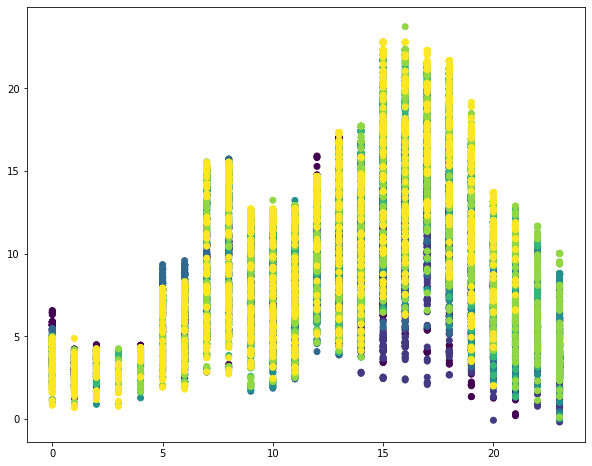

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(X_test.hour, y_pred, c=X_test.day)

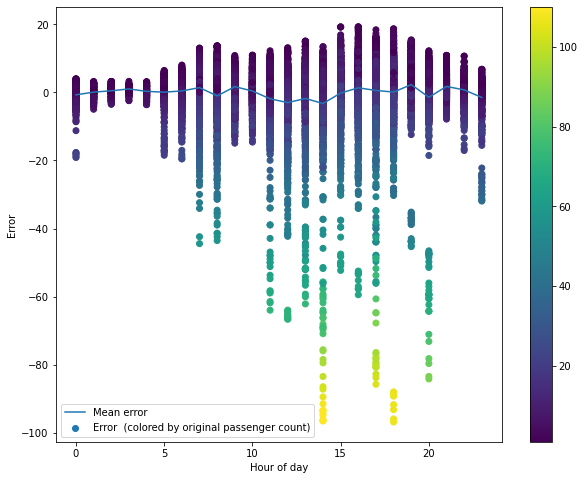

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))

ec = ax.scatter(X_test.hour, errors, c=y_test.astype(int), label="Error  (colored by original passenger count)")
ax.plot(X_test.groupby('hour').errors.mean(), label = "Mean error")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Error")
ax.legend()
plt.colorbar(ec)
plt.show()

In [68]:
error_index = X_test[X_test.errors < -80].index

<AxesSubplot:>

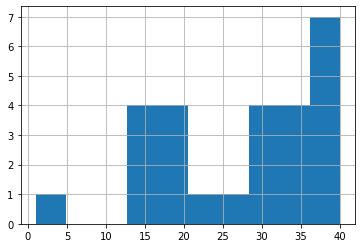

In [83]:
relevant_stops_N = [
    'MTA_803003',
    'MTA_401038',
    'MTA_400067',
    'MTA_400066', 
    'MTA_400062',
    'MTA_405014',
    'MTA_401052', 
    'MTA_404334',
    'MTA_404341',
    'MTA_400394',
    'MTA_405087',
    'MTA_400065',
    'MTA_404335',
    'MTA_401056',
    'MTA_401055',
    'MTA_401051',
    'MTA_404333',
    'MTA_401047',
    'MTA_401045',
    'MTA_401044',
    'MTA_405092',
    'MTA_401039',
]

df_m7[
    (df_m7.day == 28) &
    (df_m7.hour == 23) &
    (df_m7.next_stop_id.isin(relevant_stops_N)) &
    (df_m7.direction == 0)
].passenger_count.astype(int).hist()

In [86]:
disruption_samples = df_m7[
    (df_m7.day == 28) &
    (df_m7.hour == 23) &
    (df_m7.next_stop_id.isin(relevant_stops_N)) &
    (df_m7.direction == 0)
].index

In [90]:
df_m7['disrupted'] = False
df_m7['disrupted'].loc[disruption_samples] = True
df_m7.disrupted.sum()

/Users/Lars/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


26

Text(0, 0.5, 'Error')

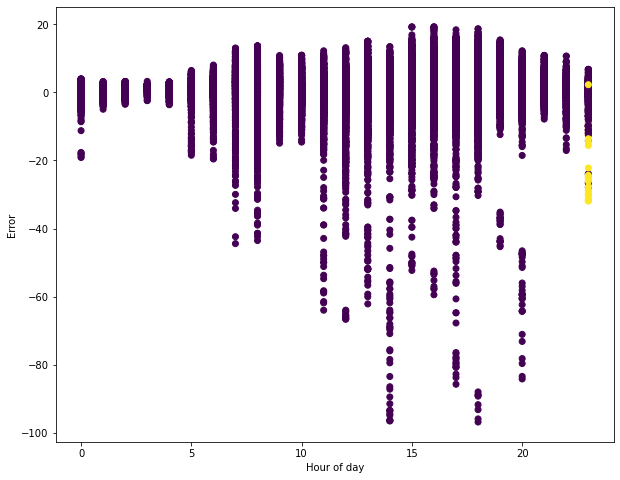

In [93]:
fig, ax = plt.subplots(figsize=(10, 8))

df_test_more = df_m7.loc[X_test.index]

ax.scatter(df_test_more.hour, errors, c=df_test_more.disrupted)
ax.set_xlabel("Hour of day")
ax.set_ylabel("Error")